In [5]:
import torch
import torchaudio
import torchvision.io
import glob
import os
from tqdm.auto import tqdm
import cv2

In [9]:
# ./vis-data-256 contains <datetime>_times.txt and <datetime>_denoised.wav, and <datetime>_denoised.mp4
# We will use the times.txt to get the timestamps of the frames in the video, a 1 second window of audio around each frame, and the material name
# times.txt has the format "<timestamp> <material name> <hit_type_1> <hit_type_2>" for each line

# Load the times.txt files in a dictionary with key as timestamp and value as a list with tuples of timestamp and material name
times_info = {}
for file in glob.glob("./vis-data-256/*_times.txt"):
    with open(file, "r") as f:
        data = f.readlines()
        data = [line.strip().split() for line in data]
        data = [(float(line[0]), line[1]) for line in data if line[1] != "None"]
        times_info[file.split("/")[-1].split("_")[0]] = data

In [10]:
for k,v in times_info.items():
    print(k)
    print(v)
    break

2015-09-30-20-56-02-193
[(1.647073, 'water'), (2.963323, 'water'), (4.252625, 'water'), (4.522365, 'water'), (5.877479, 'water'), (6.228427, 'water'), (6.499427, 'water'), (7.439615, 'water'), (7.719083, 'water'), (8.008896, 'water'), (8.301615, 'water'), (8.708354, 'water'), (8.989927, 'water'), (9.634604, 'water'), (10.109011, 'water'), (10.771895, 'water'), (11.047698, 'water'), (11.40924, 'water'), (11.687771, 'water'), (12.259958, 'water'), (12.572865, 'water'), (13.134896, 'water'), (13.461678, 'water'), (14.4075, 'water'), (14.718781, 'water'), (15.029875, 'water'), (15.304459, 'water'), (15.683594, 'water'), (15.936271, 'water'), (16.292042, 'water'), (16.600178, 'water'), (17.222605, 'water'), (17.614635, 'water'), (17.918615, 'water'), (18.271875, 'water'), (18.552458, 'water'), (19.007177, 'water'), (19.287563, 'water'), (19.685938, 'water'), (19.938583, 'water'), (20.303207, 'water'), (20.57099, 'water'), (22.161552, 'water'), (22.418261, 'water'), (22.767897, 'water'), (23

In [4]:
# Load wav file from "./vis-data-256/2015-09-30-20-56-02-193_denoised.wav"
aud_data, sr = torchaudio.load("./vis-data-256/2015-09-30-20-56-02-193_denoised.wav")

In [5]:
# length of the audio file in seconds
sr

96000

In [6]:
# Versions
print(torch.__version__)
print(torchaudio.__version__)
print(torchvision.__version__)

2.0.1+cu117
2.0.2+cu117
0.15.2+cu117


In [8]:
vid_reader = torchvision.io.VideoReader("./vis-data-256/2015-09-30-20-56-02-193_denoised.mp4")

In [19]:
frames, audio, metadata = torchvision.io.read_video("./vis-data-256/2015-09-30-20-56-02-193_denoised.mp4")

/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [48]:
frames.shape

torch.Size([841, 256, 456, 3])

## Testing IO for audio and video frames

In [111]:
for date_time, frame_info in times_info.items():
    # Load the audio and video
    # video = torch.load(f"./vis-data-256/{date_time}_denoised.mp4")
    frames, audio, metadata = torchvision.io.read_video(f"./vis-data-256/{date_time}_denoised.mp4")
    audio = audio[0]
    video_rate = metadata["video_fps"]
    audio_rate = metadata["audio_fps"]

    # Get the timestamps of the frames in the video
    frame_timestamps = [frame[0] for frame in frame_info]

    # Get the audio for each frame
    audio_frames = []
    for frame_timestamp in frame_timestamps:
        audio_start = frame_timestamp - 0.5
        audio_end = frame_timestamp + 0.5
        audio_start_idx = int(audio_start * audio_rate)
        audio_end_idx = int(audio_end * audio_rate)
        audio_frames.append(audio[audio_start_idx:audio_end_idx])
        break
    # Get the material name for each frame
    material_names = [frame[1] for frame in frame_info]

    # Get the video frames
    video_frames = []
    for frame_timestamp in frame_timestamps:
        frame_idx = int(frame_timestamp * video_rate)
        video_frames.append(frames[frame_idx])
        break
    
    # Save the audio, video, and material name
    # Create directory for each date_time
    os.makedirs(f"./vis-data-256/{date_time}", exist_ok=True)
    torch.save(audio_frames, f"./vis-data-256/{date_time}/audio_frames.pt")
    torch.save(video_frames, f"./vis-data-256/{date_time}/video_frames.pt")
    torch.save(material_names, f"./vis-data-256/{date_time}/material_names.pt")
    break

/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [105]:
def save_audio_video_material_names(timestamp):
    # Read and display the saved audio, video, and material names
    audio_frames = torch.load(f"./vis-data-256/{timestamp}/audio_frames.pt")
    video_frames = torch.load(f"./vis-data-256/{timestamp}/video_frames.pt")
    material_names = torch.load(f"./vis-data-256/{timestamp}/material_names.pt")
    print(f"Date-Time: {timestamp}")
    print(f"Number of audio frames: {len(audio_frames)}")
    print(f"Number of video frames: {len(video_frames)}")
    print(f"Number of material names: {len(material_names)}")
    print(f"Material names: {material_names}")
    
    # Display the first frame, play the first audio, and print the material name
    first_frame = video_frames[0]
    if first_frame.shape[0] != 3:
        first_frame = first_frame.permute(2, 0, 1)
    print(f"First frame: {first_frame.shape}")
    torchvision.io.write_jpeg(first_frame, f"./vis-data-256/{timestamp}/first_frame.jpg")
    print(f"Saved first frame to ./vis-data-256/{timestamp}/first_frame.jpg")
    
    first_audio = audio_frames[0]
    print(f"First audio: {first_audio.shape}")
    torchaudio.save(f"./vis-data-256/{timestamp}/first_audio.wav", first_audio.unsqueeze(0), audio_rate)
    print(f"Saved first audio to ./vis-data-256/{timestamp}/first_audio.wav")
    
    print(f"Material name for first frame: {material_names[0]}")

In [106]:
for timestamp, frame_info in times_info.items():
    print(timestamp)
    save_audio_video_material_names(timestamp)
    break

2015-09-30-20-56-02-193
Date-Time: 2015-09-30-20-56-02-193
Number of audio frames: 49
Number of video frames: 49
Number of material names: 49
Material names: ['water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water']
First frame: torch.Size([3, 256, 456])
Saved first frame to ./vis-data-256/2015-09-30-20-56-02-193/first_frame.jpg
First audio: torch.Size([96000])
Saved first audio to ./vis-data-256/2015-09-30-20-56-02-193/first_audio.wav
Material name for first frame: water


## Creating processed dataset

In [58]:
os.makedirs(f"./vis-data-256-processed/", exist_ok=True)

In [59]:
all_material_annotations = {}
for date_time, frame_info in tqdm(times_info.items(), total=len(times_info)):
    # Load the audio and video
    # video = torch.load(f"./vis-data-256/{date_time}_denoised.mp4")
    frames, audio, metadata = torchvision.io.read_video(f"./vis-data-256/{date_time}_denoised.mp4")
    audio = audio[0]
    video_rate = metadata["video_fps"]
    audio_rate = metadata["audio_fps"]

    # Get the timestamps of the frames in the video
    frame_timestamps = [frame[0] for frame in frame_info]
    material_names = [frame[1] for frame in frame_info]

    for i, frame_timestamp in tqdm(enumerate(frame_timestamps), total=len(frame_timestamps), leave=False):
        # Save the audio for each frame
        audio_start = frame_timestamp - 0.5
        audio_end = frame_timestamp + 0.5
        audio_start_idx = int(audio_start * audio_rate)
        audio_end_idx = int(audio_end * audio_rate)
        torch.save(audio[audio_start_idx:audio_end_idx].unsqueeze(0), f"./vis-data-256-processed/{date_time}_{frame_timestamp}_audio.pt")

        # Save the video frames
        frame_idx = int(frame_timestamp * video_rate)
        torch.save(frames[frame_idx].permute(2, 0, 1), f"./vis-data-256-processed/{date_time}_{frame_timestamp}_frame.pt")

        # Add the material name to all_material_annotations
        all_material_annotations[f"{date_time}_{frame_timestamp}"] = material_names[i]
    # break

torch.save(all_material_annotations, "./vis-data-256-processed/all_material_annotations.pt")

  0%|          | 0/977 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [52]:
annot = torch.load("./vis-data-256-processed/all_material_annotations.pt")
for k,v in annot.items():
    print(k, v)
    break

2015-09-30-20-56-02-193_1.647073 water


In [ ]:
sorted(glob.glob("./vis-data-256/*_times.txt"))

['./vis-data-256/2015-02-16-16-49-06_times.txt',
 './vis-data-256/2015-02-16-16-56-35_times.txt',
 './vis-data-256/2015-02-16-16-58-57_times.txt',
 './vis-data-256/2015-02-16-17-02-05_times.txt',
 './vis-data-256/2015-02-16-17-03-55_times.txt',
 './vis-data-256/2015-02-16-17-08-51_times.txt',
 './vis-data-256/2015-02-16-17-15-23_times.txt',
 './vis-data-256/2015-02-16-17-27-53_times.txt',
 './vis-data-256/2015-02-16-17-32-18_times.txt',
 './vis-data-256/2015-02-16-17-35-07_times.txt',
 './vis-data-256/2015-02-16-17-40-35_times.txt',
 './vis-data-256/2015-02-16-17-46-48_times.txt',
 './vis-data-256/2015-02-16-17-52-15_times.txt',
 './vis-data-256/2015-02-16-17-54-47_times.txt',
 './vis-data-256/2015-02-16-18-02-38_times.txt',
 './vis-data-256/2015-02-16-18-07-52_times.txt',
 './vis-data-256/2015-02-21-17-08-25_times.txt',
 './vis-data-256/2015-02-21-17-09-17_times.txt',
 './vis-data-256/2015-02-21-17-13-35_times.txt',
 './vis-data-256/2015-02-21-17-14-45_times.txt',
 './vis-data-256/201

In [ ]:
idx = 114

for key in times_info.keys():
    if idx < len(times_info[key]):
        break
    else:
        idx -= len(times_info[key])
        print(f"Skipping {key}")
key, idx
print(f"len(times_info[key]): {len(times_info[key])}")

Skipping 2015-09-30-20-56-02-193
len(times_info[key]): 78


## Testing cv2 for reading frames

In [86]:
import cv2
import torchvision.transforms as T

In [116]:
for date_time, frame_info in times_info.items():
    # Load the audio and video
    # video = torch.load(f"./vis-data-256/{date_time}_denoised.mp4")
    # frames, audio, metadata = torchvision.io.read_video(f"./vis-data-256/{date_time}_denoised.mp4")
    # audio = audio[0]
    # video_rate = metadata["video_fps"]
    # audio_rate = metadata["audio_fps"]
    print(f"datetime: {date_time}")
    cap = cv2.VideoCapture(f"./vis-data-256/{date_time}_denoised.mp4")
    
    audio, audio_rate = torchaudio.load(f"./vis-data-256/{date_time}_denoised.wav")    
    audio = audio[0]
    
    # Get the timestamps of the frames in the video
    frame_timestamps = [frame[0] for frame in frame_info]

    # Get the audio for each frame
    audio_frames = []
    for frame_timestamp in frame_timestamps:
        audio_start = frame_timestamp - 0.5
        audio_end = frame_timestamp + 0.5
        audio_start_idx = int(audio_start * audio_rate)
        audio_end_idx = int(audio_end * audio_rate)
        audio_frames.append(audio[audio_start_idx:audio_end_idx])
        break
    # Get the material name for each frame
    material_names = [frame[1] for frame in frame_info]

    # Get the video frames
    video_frames = []
    for frame_timestamp in frame_timestamps:
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_timestamp * 1000)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = (T.ToTensor()(frame) * 255).to(torch.uint8)
        video_frames.append(frame)
        break
    # Save the audio, video, and material name
    # Create directory for each date_time
    cap.release()
    os.makedirs(f"./vis-data-256/{date_time}", exist_ok=True)
    torch.save(audio_frames, f"./vis-data-256/{date_time}/audio_frames.pt")
    torch.save(video_frames, f"./vis-data-256/{date_time}/video_frames.pt")
    torch.save(material_names, f"./vis-data-256/{date_time}/material_names.pt")
    break

datetime: 2015-09-30-20-56-02-193


In [115]:
for timestamp, frame_info in times_info.items():
    print(timestamp)
    save_audio_video_material_names(timestamp)
    break

2015-09-30-20-56-02-193
Date-Time: 2015-09-30-20-56-02-193
Number of audio frames: 1
Number of video frames: 1
Number of material names: 49
Material names: ['water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water']
First frame: torch.Size([3, 256, 456])
Saved first frame to ./vis-data-256/2015-09-30-20-56-02-193/first_frame.jpg
First audio: torch.Size([96000])
Saved first audio to ./vis-data-256/2015-09-30-20-56-02-193/first_audio.wav
Material name for first frame: water


## Mel spec test

In [1]:
import whisper

In [18]:
date_time = "2015-09-29-16-35-56-1"
frame_timestamp = 30.826166
audio_length = 5
audio_rate = 96000

audio = whisper.load_audio(f"../GreatestHits/vis-data-256/{date_time}_denoised.wav", 96000)

audio_start_time = frame_timestamp - audio_length / 2
audio_start_idx = int(audio_start_time * audio_rate)
audio2 = audio[audio_start_idx : audio_start_idx + audio_rate * audio_length]
audio3 = whisper.pad_or_trim(audio2, audio_rate * audio_length)

In [21]:
audio3.shape[0]/96000

5.0

## Determine Normalization Parameters over the entire dataset

In [4]:
from dataset_utils import create_dataloaders
from tqdm.auto import tqdm

batch_size = 4
dataloader = create_dataloaders(root_dir="/home/GreatestHits/vis-data-256", batch_size=batch_size)

# Iterate over the dataset to determine normalization parameters for the images
mean = 0.
std = 0.
nb_samples = 0.
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)//6):
    data = batch["images"]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    
    if i % 20 == 0:
        print(f"i: {i}, mean: {mean/nb_samples}, std: {std/nb_samples}")
    
    if i == len(dataloader)//6 - 1:
        break
    
mean /= nb_samples
std /= nb_samples
print(f"mean: {mean}, std: {std}")


Dataset size: 28444



  0%|          | 0/1185 [00:00<?, ?it/s]

i: 0, mean: tensor([0.4936, 0.4474, 0.3354]), std: tensor([0.2400, 0.2252, 0.1811])
i: 20, mean: tensor([0.4905, 0.4470, 0.3886]), std: tensor([0.2041, 0.1950, 0.1863])
i: 40, mean: tensor([0.4803, 0.4428, 0.3825]), std: tensor([0.1968, 0.1877, 0.1787])
i: 60, mean: tensor([0.4730, 0.4389, 0.3817]), std: tensor([0.1972, 0.1879, 0.1781])
i: 80, mean: tensor([0.4704, 0.4383, 0.3829]), std: tensor([0.1961, 0.1870, 0.1777])
i: 100, mean: tensor([0.4708, 0.4368, 0.3799]), std: tensor([0.1983, 0.1898, 0.1803])
i: 120, mean: tensor([0.4711, 0.4342, 0.3770]), std: tensor([0.1993, 0.1903, 0.1812])
i: 140, mean: tensor([0.4710, 0.4334, 0.3748]), std: tensor([0.2000, 0.1908, 0.1810])
i: 160, mean: tensor([0.4683, 0.4290, 0.3708]), std: tensor([0.2002, 0.1915, 0.1821])
i: 180, mean: tensor([0.4667, 0.4274, 0.3697]), std: tensor([0.2007, 0.1920, 0.1824])
i: 200, mean: tensor([0.4663, 0.4259, 0.3679]), std: tensor([0.2006, 0.1919, 0.1815])
i: 220, mean: tensor([0.4672, 0.4264, 0.3681]), std: tensor(

## Find all material names, create dict

In [1]:
from dataset_utils import create_dataloaders
loader = create_dataloaders(root_dir="/home/GreatestHits/vis-data-256", batch_size=4)


Dataset size: 28444



In [5]:
len(loader.dataset.times_info)
loader.dataset.material_names_dict

{'carpet': 0,
 'ceramic': 1,
 'cloth': 2,
 'dirt': 3,
 'drywall': 4,
 'glass': 5,
 'grass': 6,
 'gravel': 7,
 'leaf': 8,
 'metal': 9,
 'paper': 10,
 'plastic': 11,
 'plastic-bag': 12,
 'rock': 13,
 'tile': 14,
 'water': 15,
 'wood': 16}

In [8]:
import matplotlib.pyplot as plt
import torch

In [38]:
loss_hist = torch.load("loss_history.pth")
loss_hist_ema = []
l = loss_hist[0]
a = 0.999
for val in loss_hist:
    l = a * l + (1 - a) * val
    loss_hist_ema.append(l)

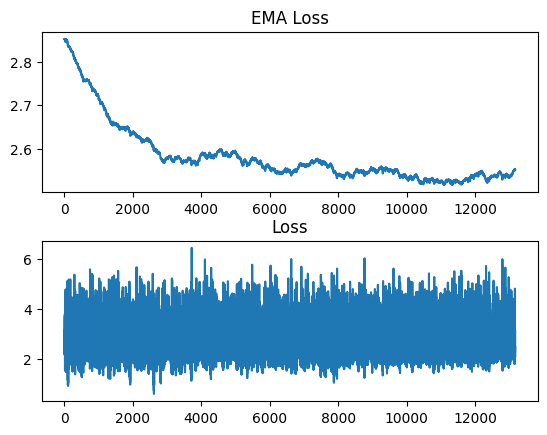

In [39]:
plt.subplot(2,1,1)
plt.title("EMA Loss")
plt.plot(loss_hist_ema)

plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(loss_hist)

plt.subplots_adjust(hspace=0.3)
plt.show()